# Evaluate Model with Data Generated for It

In [306]:
!ls ../resources/nmt_output/en_ja

jiji_onto_ami_conver_train_1-to-1_en_ja_test
jiji_onto_ami_conver_train_1-to-1_en_ja_test.ref
jiji_onto_ami_conver_train_1-to-1_en_ja_valid
jiji_onto_ami_conver_train_1-to-1_en_ja_valid.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_test
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_test.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_valid
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_valid.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_test
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_test.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_valid
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_valid.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3_test
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3_test.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3_valid
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3_valid.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_4_test


In [319]:
!ls ../resources/hybrid_nmt_output_appended/en_ja/*noisy*valid.ref

../resources/hybrid_nmt_output_appended/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc_Previous_1_valid.ref
../resources/hybrid_nmt_output_appended/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc_Previous_2_valid.ref
../resources/hybrid_nmt_output_appended/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc_Previous_3_valid.ref
../resources/hybrid_nmt_output_appended/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc_Previous_4_valid.ref
../resources/hybrid_nmt_output_appended/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc_Previous_5_valid.ref


In [307]:
!cat ../resources/nmt_output/results.txt

en_ja
------------------------------
jiji_onto_ami_conver_train_1-to-1_en_ja
	valid: 15.11	test: 14.65
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1
	valid: 14.82	test: 15.33
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2
	valid: 14.94	test: 15.20
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3
	valid: 15.01	test: 14.98
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_4
	valid: 14.69	test: 15.38
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_5
	valid: 15.46	test: 15.43
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_noisy_jesc
	valid: 14.98	test: 15.67

ja_en
------------------------------
jiji_onto_ami_conver_train_1-to-1_ja_en
	valid: 16.90	test: 17.10
jiji_onto_ami_conver_train_2-to-1_ja_en_context_bias_1
	valid: 17.13	test: 17.21
jiji_onto_ami_conver_train_2-to-1_ja_en_context_bias_2
	valid: 17.31	test: 17.46
jiji_onto_ami_conver_train_2-to-1_ja_en_context_bias_3
	valid: 17.14	test: 16.89
jiji_onto_ami_conver_train_2-to-1_ja_en_context_bias_

In [308]:
import pandas as pd
import glob
from collections import defaultdict
import os
import sacrebleu
import matplotlib.pyplot as plt

In [420]:
def get_table(file_list, base_list=None):
    table = dict()
    for ref_file in base_list:
        key = os.path.split(ref_file)[-1].split('.')[0]
        key = f"base_{key.split('_Previous_')[1][0]}"
        hypo_file = os.path.splitext(ref_file)[0]
        table[key] = []
        with open(ref_file) as ref_source, open(hypo_file) as hypo_source:
            for ref, hypo in zip(ref_source, hypo_source):
                table[key].append((hypo.strip(), sacrebleu.corpus_bleu(hypo, ref).score))
    for ref_file in file_list:
        key = os.path.split(ref_file)[-1].split('.')[0]
        if '1-to-1' in key:
            key = 'model_bias_0'
            base_key = None
        else:
            key = f"model_bias_{key.split('_bias_')[1][0]}"
            base_key = f"base_{key[-1]}"
        hypo_file = os.path.splitext(ref_file)[0]
        table["reference"] = []
        table[key] = []
        with open(ref_file) as ref_source, open(hypo_file) as hypo_source:
            for index, (ref, hypo) in enumerate(zip(ref_source, hypo_source)):
                table["reference"].append(ref.strip())
                if base_key:
                    base_score = table[base_key][index][1]
                    table[key].append([hypo.strip(), sacrebleu.corpus_bleu(hypo, ref).score - base_score])
                else:
                    table[key].append([hypo.strip(), sacrebleu.corpus_bleu(hypo, ref).score])
    for index in range(1, 6):
        table.pop(f"base_{index}")
        for sent_id, item in enumerate(table[f"model_bias_{index}"]):
            table[f"model_bias_{index}"][sent_id][1] += table['model_bias_0'][sent_id][1]
    return pd.DataFrame(table)

In [421]:
en_ja_valid = get_table(glob.glob("../resources/nmt_output/en_ja/*valid.ref"), glob.glob("../resources/hybrid_nmt_output_appended/en_ja/*noisy*valid.ref"))
en_ja_test = get_table(glob.glob("../resources/nmt_output/en_ja/*test.ref"), glob.glob("../resources/hybrid_nmt_output_appended/en_ja/*noisy*test.ref"))
ja_en_valid = get_table(glob.glob("../resources/nmt_output/ja_en/*valid.ref"), glob.glob("../resources/hybrid_nmt_output_appended/en_ja/*noisy*valid.ref"))
ja_en_test = get_table(glob.glob("../resources/nmt_output/ja_en/*test.ref"), glob.glob("../resources/hybrid_nmt_output_appended/en_ja/*noisy*test.ref"))

In [422]:
en_ja_valid

,reference,model_bias_3,model_bias_2,model_bias_0,model_bias_4,model_bias_5,model_bias_1
0,こんにちは 、 a 社 の バッグ を 取り に 来 まし た 。,"[こんにちは 、 a 社用 袋 を 選ん で い ます 。, -10.60260049013...","[もしもし 、 a 社 の 袋 を いくつ か 買い上げ まし た 。, 5.0992931...","[もしもし 、 a 社用 の 袋 を 選ん で い ます 。, 7.835643838636...","[こんにちは 、 a 社用 の 袋 を いくつ か 取り まし た 。, -2.416953...","[こんにちは 、 a 社 の バッグ を いくつ か 買い上げ ます 。, 25.23522...","[もしもし 、 a 社用 の 袋 を いくつ か 買い上げ まし た 。, -8.09075..."
1,お 名前 を 伺え ます か ?,"[お 名前 を 教え て いただけ ます か ?, 33.425818975954854]","[お 名前 を 教え て いただけ ます か ?, 33.425818975954854]","[お 名前 を 教え て いただけ ます か ?, 29.84745896009822]","[お 名前 を お願い し ます 。, 29.84745896009822]","[お 名前 を いただけ ます か ?, 44.69172170590859]","[名前 を 教え て いただけ ます か ?, 29.427017713715166]"
2,サム リー です 。,"[サム リー です 。, 100.00000000000004]","[サム リー です 。, 100.00000000000004]","[サム リー です 。, 100.00000000000004]","[サム リー です 。, 100.00000000000004]","[サム リー です 。, 100.00000000000004]","[サム リー です 。, 100.00000000000004]"
3,注文 番号 も 伺っ て いい です か ?,"[注文 番号 も もらっ て も いい です か ?, 18.868012259906124]","[オーダー 番号 も お願い でき ます か ?, -6.629116239182949]","[注文 番号 も もらっ て も いい です か ?, 39.281465090051285]","[注文 番号 も 教え て いただけ ます か ?, 2.943446056264854]","[注文 番号 も お願い でき ます か ?, 2.397907524184454]","[注文 番号 も 教え て いただけ ます か ?, 2.943446056264854]"
4,はい 、 47238 です 。,"[はい 、 47238 です 。, 100.00000000000004]","[はい 、 4 万 238 です 。, 18.575057999133605]","[はい 、 47238 です 。, 100.00000000000004]","[はい 、 47238 です 。, 100.00000000000004]","[はい 、 47238 です 。, 100.00000000000004]","[はい 、 47238 です 。, 100.00000000000004]"
...,...,...,...,...,...,...,...
2046,うち の スーパー は 作りたて の 新しい もの を 提供 する こと で 他 と 差別 ...,"[生鮮 品 を 提供 し 、 他 の スーパー と の 差別 化 を 図る 。, -19.4...","[生鮮 な もの を 提供 し て 他 の スーパー と 差別 化 し まし た 。, 23...",[他 の スーパー と の 差別 化 は 、 新鮮 で 作ら れ た もの を 提供 し て...,"[新しい もの を 提供 し 、 他 の スーパー と 差別 化 し て い ます 。, 4...","[生鮮 な 製品 を 提供 し て 他 の スーパー と 差別 化 し まし た 。, -9...",[他社 の スーパー と は 、 新鮮 な もの を 提供 し て 差別 化 し て い ま...
2047,なので 新しい もの は 古い もの より 手前 に 並べ て ください 。,"[年配 の 前 に 新た に 作ら れ た 項目 を お 持ち ください 。, 8.6903...","[新しい 商品 は 古い 方 で ご 用意 ください 。, 12.170462602930085]","[古い もの より 前 に 新品 を ご 用意 ください 。, 15.30793815180...","[年配 の もの は 、 年配 の 商品 を 前面 に 置い て ください 。, 15.68...","[年配 の 前 に 新品 を ご 用意 ください 。, 9.689429697791182]","[古い 方 で 新品 を ご 用意 ください 。, 9.639869889310955]"
2048,わかり まし た 、 並べ て き まし た 。,"[わかり まし た 、 他 の ところ に 置い て おき まし た 。, 30.52736...","[了解 し まし た 、 僕 は 行っ て 、 残り を 置い て おき まし た 。, 1...","[わかり まし た 、 残り の 部分 に 置い て おい た し まし た 。, 22.8...",[なるほど 、 僕 は 行き まし た よ 、 残り は 置い て おい た し まし た ...,[わかり まし た 、 私 が 行っ たり 、 残り を 置い て おい たり し まし た...,"[わかり まし た 、 残り は 置い て おい た し まし た 。, 30.527363..."
2049,では 同じ 中華 丼 を あと 10 個 作っ て ください 。,"[では 、 さらに 10 台 を 中華 民 に し て ください 。, 52.1373807...","[では 、 さらに 「 中華 圏 」 の 10 本 を お願い し ます 。, 41.855...","[では 、 さらに 10 個 作っ て ください 。, 43.742343691381734]","[では 、 同じ 「 中国 中華 」 の 10 個 を お願い し ます 。, 45.840...","[では 、 さらに 10 名 で 「 中国 」 に し て ください 。, 48.99908...","[じゃあ 、 同じ 「 中国 風 」 を 10 個 用意 し て ください 。, 51.30..."


In [330]:
[(key, *value) for key, value in dict(en_ja_valid.loc[:, en_ja_valid.columns != 'reference'].iloc[0]).items()]

[('model_bias_3', 'こんにちは 、 a 社用 袋 を 選ん で い ます 。', 13.215955651112736),
 ('model_bias_2', 'もしもし 、 a 社 の 袋 を いくつ か 買い上げ まし た 。', 28.917849332325716),
 ('model_bias_0', 'もしもし 、 a 社用 の 袋 を 選ん で い ます 。', 7.835643838636099),
 ('model_bias_4', 'こんにちは 、 a 社用 の 袋 を いくつ か 取り まし た 。', 21.401603033752966),
 ('model_bias_5', 'こんにちは 、 a 社 の バッグ を いくつ か 買い上げ ます 。', 49.05378138718246),
 ('model_bias_1', 'もしもし 、 a 社用 の 袋 を いくつ か 買い上げ まし た 。', 15.727800941615351),
 ('base_5', 'こんにちは 、 a 社 の 袋 を 拾い ます 。', 31.654199979887586),
 ('base_4', 'こんにちは 、 a 社 の 袋 を 拾い ます 。', 31.654199979887586),
 ('base_2', 'こんにちは 、 a 社 の 袋 を 拾い ます 。', 31.654199979887586),
 ('base_1', 'こんにちは 、 a 社 の 袋 を 拾い ます 。', 31.654199979887586),
 ('base_3', 'こんにちは 、 a 社 の 袋 を 拾い ます 。', 31.654199979887586)]

In [430]:
def get_oracle(table):
    results = {"hypothesis": [], "reference": []}
    for index, row in table.loc[:, table.columns != 'reference'].iterrows():
        line = [(key, *value) for key, value in dict(row).items()]
        results["hypothesis"].append(max(line, key=lambda x: x[-1])[:-1])
        results["reference"].append(table.iloc[index]['reference'])
    return results

In [431]:
oracle_en_ja_valid = get_oracle(en_ja_valid)
oracle_en_ja_test = get_oracle(en_ja_test)
oracle_ja_en_valid = get_oracle(ja_en_valid)
oracle_ja_en_test = get_oracle(ja_en_test)

In [432]:
oracle_ja_en_valid

{'hypothesis': [('model_bias_0', 'hi, i came in the bag of company a.'),
  ('model_bias_0', 'can you tell me your name?'),
  ('model_bias_0', 'this is sam lee.'),
  ('model_bias_0', 'can i ask you the order number?'),
  ('model_bias_0', "yes, it's 47238."),
  ('model_bias_5', 'yes, we have bags ready.'),
  ('model_bias_4', 'i will take care of greg.'),
  ('model_bias_0', 'hi sam.'),
  ('model_bias_3', 'my name is greg.'),
  ('model_bias_1', 'hi, my name is sam lee from company a.'),
  ('model_bias_3',
   'i understand your name, but it was nice to see your faces.'),
  ('model_bias_2', 'we have bags in the deck so we can get them right away.'),
  ('model_bias_0', "please sign this invoice before i'm heading."),
  ('model_bias_0', 'okay.'),
  ('model_bias_5', "okay, let's head out then."),
  ('model_bias_1',
   'the bags are pretty heavy so we will use a small form to load it in your car.'),
  ('model_bias_0', 'which car?'),
  ('model_bias_5', "it's black suv over there."),
  ('model_bia

In [435]:
def save_oracle(oracle, save_path, suffix=""):
    with open(save_path + f'/oracle_table_{suffix}.tsv', 'w') as table, open(save_path + f'/oracle_{suffix}.sys', 'w') as target:
        table.write("model\treference\thypothesis\n")
        for (model, sys), ref in zip(oracle['hypothesis'], oracle['reference']):
            table.write('\t'.join((model, ref, sys)) + '\n')
            target.write(sys + '\n')
    return save_path + f'/oracle_table_{suffix}.tsv'

In [436]:
save_oracle(oracle_en_ja_valid, '../resources/nmt_output/en_ja', "valid")
save_oracle(oracle_ja_en_valid, '../resources/nmt_output/ja_en', "valid")
save_oracle(oracle_en_ja_test, '../resources/nmt_output/en_ja', "test")
save_oracle(oracle_ja_en_test, '../resources/nmt_output/ja_en', "test")

'../resources/nmt_output/ja_en/oracle_table_test.tsv'

In [718]:
enja_table_valid = pd.read_csv('../resources/nmt_output/en_ja/oracle_table_valid.tsv', delimiter='\t')
jaen_table_valid = pd.read_csv('../resources/nmt_output/ja_en/oracle_table_valid.tsv', delimiter='\t')
enja_table_test = pd.read_csv('../resources/nmt_output/en_ja/oracle_table_test.tsv', delimiter='\t')
jaen_table_test = pd.read_csv('../resources/nmt_output/ja_en/oracle_table_test.tsv', delimiter='\t')

In [619]:
enja_table_valid

,model,reference,hypothesis
0,model_bias_5,こんにちは 、 a 社 の バッグ を 取り に 来 まし た 。,こんにちは 、 a 社 の バッグ を いくつ か 買い上げ ます 。
1,model_bias_5,お 名前 を 伺え ます か ?,お 名前 を いただけ ます か ?
2,model_bias_3,サム リー です 。,サム リー です 。
3,model_bias_0,注文 番号 も 伺っ て いい です か ?,注文 番号 も もらっ て も いい です か ?
4,model_bias_3,はい 、 47238 です 。,はい 、 47238 です 。
...,...,...,...
2046,model_bias_4,うち の スーパー は 作りたて の 新しい もの を 提供 する こと で 他 と 差別 ...,新しい もの を 提供 し 、 他 の スーパー と 差別 化 し て い ます 。
2047,model_bias_4,なので 新しい もの は 古い もの より 手前 に 並べ て ください 。,年配 の もの は 、 年配 の 商品 を 前面 に 置い て ください 。
2048,model_bias_3,わかり まし た 、 並べ て き まし た 。,わかり まし た 、 他 の ところ に 置い て おき まし た 。
2049,model_bias_3,では 同じ 中華 丼 を あと 10 個 作っ て ください 。,では 、 さらに 10 台 を 中華 民 に し て ください 。


In [509]:
from collections import defaultdict

def corpus_by_model(table, key='model'):
    result = defaultdict(lambda : defaultdict(list))
    for index, row in table.iterrows():
        result[row[key]]['reference'].append(row['reference'])
        result[row[key]]['hypothesis'].append(row['hypothesis'])
    for key, value in result.items():
        value['reference'] = [value['reference']]
    return result

In [723]:
enja_corpus_valid = corpus_by_model(enja_table_valid)
enja_corpus_test = corpus_by_model(enja_table_test)
jaen_corpus_valid = corpus_by_model(jaen_table_valid)
jaen_corpus_test = corpus_by_model(jaen_table_test)

In [729]:
enja_corpus_valid = corpus_by_model(enja_table_valid, 'context_sentence_distance')
enja_corpus_test = corpus_by_model(enja_table_test, 'context_sentence_distance')
jaen_corpus_valid = corpus_by_model(jaen_table_valid, 'context_sentence_distance')
jaen_corpus_test = corpus_by_model(jaen_table_test, 'context_sentence_distance')

In [695]:
def calculate_bleu(table):
    result = defaultdict(dict)
    for key, value in table.items():
        print(key)
        corpus_score = sacrebleu.corpus_bleu(value['hypothesis'], value['reference']).score
        sentence_scores = [sacrebleu.sentence_bleu(hypo, ref).score for hypo, ref in zip(value['hypothesis'], value['reference'][0])]
        sentence_scores_mean = sum(sentence_scores) / len(sentence_scores)
        print(corpus_score)
        print(sentence_scores_mean)
        result[key]['corpus_bleu'] = corpus_score
        result[key]['sentence_bleu_mean'] = sentence_scores_mean
    print('\n')
    result = dict(sorted(result.items(), key=lambda x : x[0]))
    return result

In [730]:
enja_bleu_valid = calculate_bleu(enja_corpus_valid)
enja_bleu_test = calculate_bleu(enja_corpus_test)
jaen_bleu_valid = calculate_bleu(jaen_corpus_valid)
jaen_bleu_test = calculate_bleu(jaen_corpus_test)

0
21.05486402772991
17.42854041225216
3
22.91612034326156
19.416762087169666
5
21.250078822508563
15.603211657478727
4
19.114256947234743
14.326287997711711
1
20.406281891799274
13.897162737728861
2
19.217161323570036
13.49826291079178


0
21.723736486063693
19.67997939133757
1
21.93887836392414
16.07421312010925
4
19.915827663589788
14.951113021344321
5
23.471359670852305
22.838577085378308
3
19.97953172936202
15.834723257288315
2
18.205079033945502
12.695384168790525


0
14.226016777923537
10.54400109106912
5
22.74881671815488
18.01866682742562
4
26.423846211309566
22.243989578918193
3
24.61736016016517
16.96646684844117
1
30.528505094408057
27.144791859087412
2
27.64211368768251
23.431465258354812


0
15.374996735551015
12.569197666138184
4
26.526268576756127
21.00821683753693
1
26.4499666541847
20.095649386358097
5
24.137076459445943
16.378882162381547
2
29.78015593932259
27.65363360133504
3
23.8217650722459
16.864836678307498




In [751]:
enja_table_valid.head(10)

,model,reference,hypothesis,context_sentence_distance
0,5,こんにちは 、 a 社 の バッグ を 取り に 来 まし た 。,こんにちは 、 a 社 の バッグ を いくつ か 買い上げ ます 。,0
1,5,お 名前 を 伺え ます か ?,お 名前 を いただけ ます か ?,0
2,3,サム リー です 。,サム リー です 。,0
3,0,注文 番号 も 伺っ て いい です か ?,注文 番号 も もらっ て も いい です か ?,0
4,3,はい 、 47238 です 。,はい 、 47238 です 。,3
5,5,はい 、 バッグ は ご 用意 でき て おり ます 。,はい 、 お 持ち の 袋 を ご 用意 し て おり ます 。,5
6,4,あと は グレッグ が ご 対応 さ せ て いただき ます 。,残り は お 休み し ます 。,4
7,3,こんにちは 、 サム さん です ね 。,こんにちは 、 サム さん 。,3
8,3,グレッグ と 申し ます 。,気に入り まし た 。,3
9,5,こんにちは 、 私 は a 社 の サム リー と 申し ます 。,a 社 の サム リー と 申し ます 。,5


In [749]:
ja_en_valid.head(10)

,reference,model_bias_1,model_bias_2,model_bias_5,model_bias_0,model_bias_4,model_bias_3
0,"hi there, i'm picking up some bags for company a.","[hi, i've been taking out bags of company a., ...","[hi, i brought the bags from company a., -1.97...","[hi, i got a bag from company a., -2.650142741...","[hi, i came in the bag of company a., 14.47371...","[hi, i've got a bag of company a., -2.65014274...","[hi, i came out of company a's bag., -12.32197..."
1,can i get your name please?,"[can you tell me your name?, 4.970300424960975]","[may i ask your name?, 5.691820189195235]","[may i ask your name?, 5.691820189195235]","[can you tell me your name?, 15.619699684601281]","[can you tell me your name?, 4.970300424960975]","[may i ask your name?, 5.691820189195235]"
2,it's sam lee.,"[this is sam lee., -20.47292712329501]","[this is sam lee., -20.47292712329501]","[this is sam lee., -20.47292712329501]","[this is sam lee., 39.76353643835252]","[this is sam lee., -20.47292712329501]","[this is sam lee., -20.47292712329501]"
3,can i also get your order number?,"[may i ask your order number?, 3.838731422586271]","[may i ask for the order number?, -11.75666908...","[may i ask you the order number?, -11.75666908...","[can i ask you the order number?, 25.848657697...","[can i ask you the order number?, -7.997602524...","[can i ask you the order number too?, -19.5874..."
4,"yes, it is 47238.","[yes, it's 47238., -50.52614091181617]","[yes, it's 47238., -50.52614091181617]","[yes, it's 47238., -50.52614091181617]","[yes, it's 47238., 24.736929544091932]","[yes, it's 47238., -50.52614091181617]","[yes, it's 47238., -50.52614091181617]"
5,"okay, yes we have the bags ready for you.","[yes, the bags are ready., 7.7923040639406]","[yes, the bags can be prepared., 7.57570336504...","[yes, we have bags ready., 10.095400242358242]","[yes, the bags are ready., 9.761739612102298]","[yes, we have bags ready., 10.095400242358242]","[yes, we have bags ready., 10.095400242358242]"
6,i'll have greg take care of the rest for you.,"[i will also take care of gregs., 15.053292765...","[i will also take care of gregs., 14.873136313...","[also, we will handle greg., 5.390340068499407]","[and greg will handle it., 4.194930905450255]","[i will take care of greg., 16.531145380005924]","[also, gregs will handle it., 3.3998562100502907]"
7,"hi there, you must be sam.","[hi sam., -30.28512683288236]","[hi sam., -30.28512683288236]","[hi sam., -30.28512683288236]","[hi sam., 0.0]","[hi sam., -30.28512683288236]","[hi sam., -30.28512683288236]"
8,i'm greg.,"[my name is greg., 30.025381935758034]","[my name is gregg., 32.046525479717545]","[my name is greg., 30.025381935758034]","[my name is greg., 21.3643503198117]","[my name is greg., 32.04652547971755]","[my name is greg., 42.7287006396234]"
9,hi there i'm sam lee from company a.,"[hi, my name is sam lee from company a., 64.84...","[hi, my name is sam lee from company a., 64.84...","[hi, my name is sam lee from company a., 64.84...","[hi, my name is sam lee from company a., 47.98...","[hi, my name is sam lee from company a., 64.84...","[hi, my name is sam lee from company a., 64.84..."


In [750]:
jaen_table_valid[jaen_table_valid['context_sentence_distance'] == 0]['hypothesis']

0                     hi, i came in the bag of company a.
1                              can you tell me your name?
2                                        this is sam lee.
3                         can i ask you the order number?
4                                        yes, it's 47238.
                              ...                        
2045    i think it would be possible if it's a normal ...
2046    our supermarket is making and providing new th...
2047    so just lay out a new one earlier than the old...
2048                                okay, i've set it up.
2050                                                okay.
Name: hypothesis, Length: 684, dtype: object

In [770]:
import matplotlib.pyplot as plt

#ax1 = enja_bleu_valid['sentence_bleu_mean'].plot(rot=90, kind='bar')
#ax2 = enja_table_valid.groupby('model').count()['reference'].plot(rot=90)
def plot_result(table, bleu, bleu_type='sentence_bleu_mean'):
    fig, ax1 = plt.subplots()
    color = 'tab:cyan'
    ax1.set_xlabel('context distance')
    ax1.set_ylabel('average sentence bleu', color=color)  # we already handled the x-label with ax1
    ax1.bar(list(bleu.keys()), pd.DataFrame(bleu).T[bleu_type], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'black'
    ax2.set_ylabel('count', color=color)
    counter = table.groupby('model').count()
    ax2.plot(counter.index, counter['reference'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    return fig

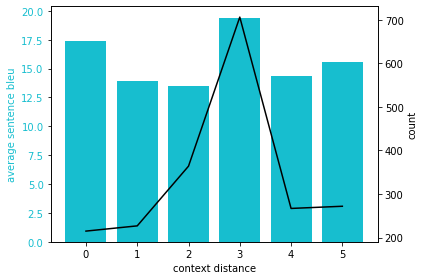

In [771]:
fig = plot_result(enja_table_valid, enja_bleu_valid)
fig.savefig('/home/litong/context_translation/resources/nmt_output/enja_oracle_distribution_valid.png')

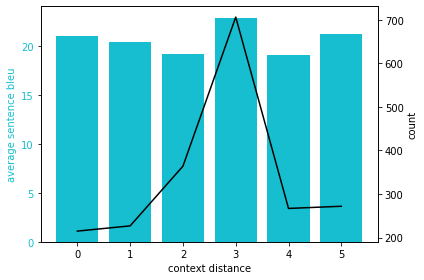

In [772]:
fig = plot_result(enja_table_valid, enja_bleu_valid, 'corpus_bleu')

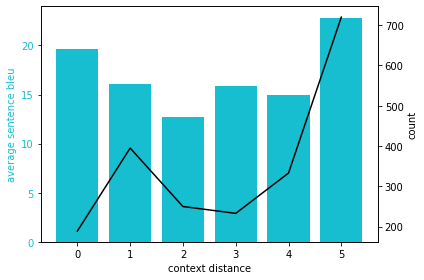

In [773]:
fig = plot_result(enja_table_test, enja_bleu_test)
fig.savefig('/home/litong/context_translation/resources/nmt_output/enja_oracle_distribution_test.png')

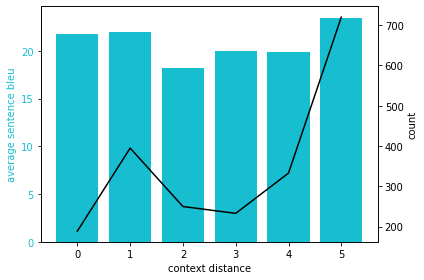

In [774]:
fig = plot_result(enja_table_test, enja_bleu_test, 'corpus_bleu')

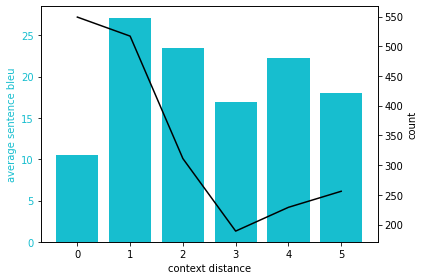

In [775]:
fig = plot_result(jaen_table_valid, jaen_bleu_valid)
fig.savefig('/home/litong/context_translation/resources/nmt_output/jaen_oracle_distribution_valid.png')

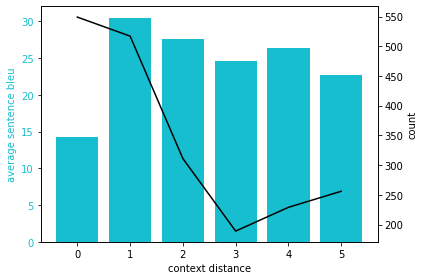

In [776]:
fig = plot_result(jaen_table_valid, jaen_bleu_valid, 'corpus_bleu')

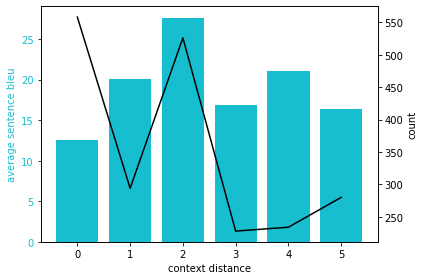

In [777]:
fig = plot_result(jaen_table_test, jaen_bleu_test)
fig.savefig('/home/litong/context_translation/resources/nmt_output/jaen_oracle_distribution_test.png')

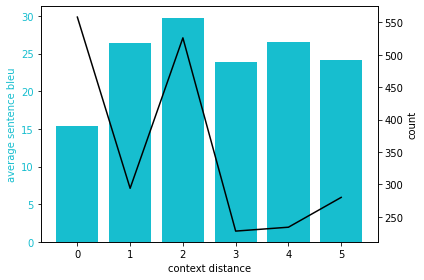

In [778]:
fig = plot_result(jaen_table_test, jaen_bleu_test, 'corpus_bleu')

In [719]:
def readable_model_name(model):
    return int(model[-1])

In [720]:
enja_table_valid['model'] = enja_table_valid['model'].apply(readable_model_name)
jaen_table_valid['model'] = jaen_table_valid['model'].apply(readable_model_name)
enja_table_test['model'] = enja_table_test['model'].apply(readable_model_name)
jaen_table_test['model'] = jaen_table_test['model'].apply(readable_model_name)

In [712]:
jaen_table_test[(jaen_table_test['model'] == 0) & (jaen_table_test['context_sentence_distance'] != 0)]

,model,reference,hypothesis,context_sentence_distance


In [713]:
jaen_table_test.groupby('context_sentence_distance').count()

,model,reference,hypothesis
context_sentence_distance,,,
0,688,688,688
1,286,286,286
2,486,486,486
3,212,212,212
4,217,217,217
5,231,231,231


In [721]:
def get_real_context(table, lengths):
    real_bias = []
    start = 0
    for length in lengths:
        index = 0
        for _, row in table.iloc[start:start + length].iterrows():
            model = int(row['model'])
            if index < model:
                real_bias.append(0)
            else:
                real_bias.append(model)
            index += 1
        start += length
    #table['context_sentence_distance'] = list(map(str, real_bias))
    table['context_sentence_distance'] = real_bias
    #return real_bias

In [722]:
get_real_context(enja_table_valid, valid_lengths)
get_real_context(enja_table_test, test_lengths)
get_real_context(jaen_table_valid, valid_lengths)
get_real_context(jaen_table_test, test_lengths)

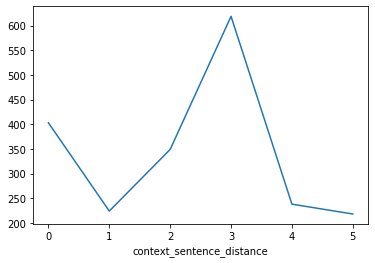

In [714]:
enja_table_valid.groupby('context_sentence_distance').count()['reference'].plot()

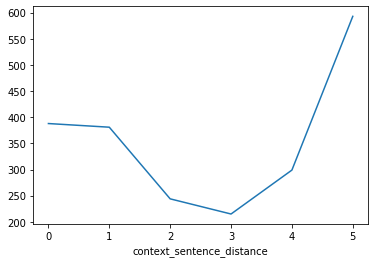

In [715]:
enja_table_test.groupby('context_sentence_distance').count()['reference'].plot()

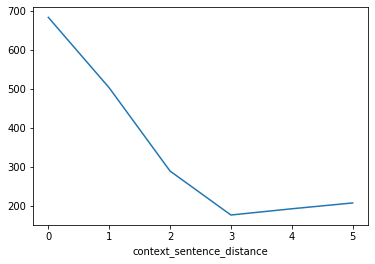

In [716]:
jaen_table_valid.groupby('context_sentence_distance').count()['reference'].plot()

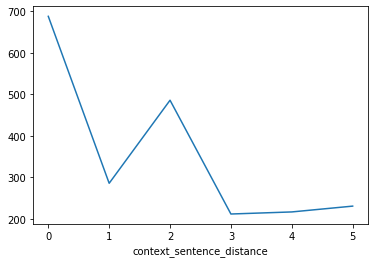

In [717]:
jaen_table_test.groupby('context_sentence_distance').count()['reference'].plot()

In [386]:
def merge_table(a, b):
    result = {}
    result['valid'] = dict(a.groupby('context_sentence_distance').count()['reference'])
    result['test'] = dict(b.groupby('context_sentence_distance').count()['reference'])
    return result

In [387]:
enja_table = merge_table(enja_table_test, enja_table_valid)
jaen_table = merge_table(jaen_table_test, jaen_table_valid)

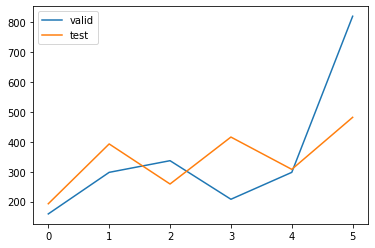

In [388]:
ax = pd.DataFrame(enja_table).plot()

In [389]:
ax.figure.savefig('/home/litong/context_translation/resources/nmt_output/enja_oracle_distribution.png')

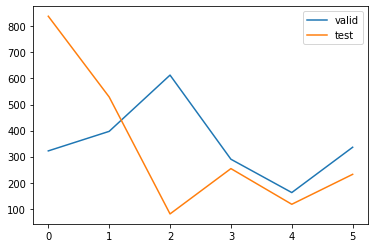

In [390]:
ax = pd.DataFrame(jaen_table).plot()
ax.figure.savefig('/home/litong/context_translation/resources/nmt_output/jaen_oracle_distribution.png')

In [212]:
train_path = '/home/litong/context_translation/resources/train_77b9dbd0538187438b8dd13a8f6b935c.pkl'
valid_path = '/home/litong/context_translation/resources/valid_0a06896723176aff827aac15a2e1ac94.pkl'
test_path = '/home/litong/context_translation/resources/test_312c4d4a71cc6fc659e7a08be8346726.pkl'

In [239]:
import pickle
def get_lengths(path):
    with open(path, 'rb') as source:
        data = pickle.load(source)
    return [len(doc["pairs"]) for doc in data.values()]

In [240]:
valid_lengths = get_lengths(valid_path)
test_lengths = get_lengths(test_path)

In [241]:
sum(test_lengths)

2120

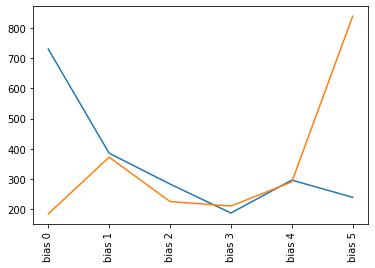

In [113]:
plt.xticks(rotation=90)
plt.plot([f"bias {index}" for index in range(0, 6)], enja_table.groupby('model').count()['reference'], label="enja")
plt.plot([f"bias {index}" for index in range(0, 6)], jaen_table.groupby('model').count()['reference'], label="jaen")

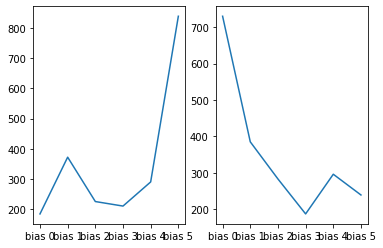

In [93]:
plt.subplot(1, 2, 1)
plt.plot([f"bias {index}" for index in range(0, 6)], jaen_table.groupby('model').count()['reference'], label="jaen")
plt.subplot(1, 2, 2)
plt.plot([f"bias {index}" for index in range(0, 6)], enja_table.groupby('model').count()['reference'], label="enja")

In [55]:
!cat ../resources/nmt_output/en_ja/oracle.sys | sacrebleu -b -w 2 ../resources/nmt_output/en_ja/jiji_onto_ami_conver_train_1-to-1_en_ja.ref
!cat ../resources/nmt_output/ja_en/oracle.sys | sacrebleu -b -w 2 ../resources/nmt_output/ja_en/jiji_onto_ami_conver_train_1-to-1_ja_en.ref

22.31
25.01


# Evaluate Model with All Kind of Data

In [68]:
!ls ../resources/hybird_nmt_output/en_ja

jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_1
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_1.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_2
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_2.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_3
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_3.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_4
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_4.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_5
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1_Bias_5.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_Bias_1
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_Bias_1.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_Bias_2
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_Bias_2.ref
jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2_Bias_3
jiji_onto_ami_conver_train_2-to-1_en_ja_co

In [99]:
os.path.splitext(glob.glob("../resources/hybird_nmt_output/en_ja/*ref")[0])

('../resources/hybird_nmt_output/en_ja/jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_4_Bias_3',
 '.ref')

In [101]:
for direction in ("en_ja", "ja_en"):
    for bias in range(1, 6):
        table = get_table(glob.glob(f"../resources/hybird_nmt_output/{direction}/*bias_{bias}*ref"))
        oracle = get_oracle(table)
        tsv_path = save_oracle(oracle, table["reference"], f"../resources/hybird_nmt_output/{direction}/", f"bias_{bias}_model")

In [102]:
for direction in ("en_ja", "ja_en"):
    for bias in range(1, 6):
        table = get_table(glob.glob(f"../resources/hybird_nmt_output/{direction}/*Bias_{bias}*ref"))
        oracle = get_oracle(table)
        tsv_path = save_oracle(oracle, table["reference"], f"../resources/hybird_nmt_output/{direction}/", f"bias_{bias}_data")

In [112]:
!cat ../resources/hybird_nmt_output/results.txt

en_ja
------------------------------
Model -> jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_1
	Data -> Bias_1: 15.33
	Data -> Bias_2: 15.08
	Data -> Bias_3: 15.00
	Data -> Bias_4: 15.18
	Data -> Bias_5: 14.92
Model -> jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_2
	Data -> Bias_1: 15.41
	Data -> Bias_2: 15.20
	Data -> Bias_3: 15.45
	Data -> Bias_4: 15.41
	Data -> Bias_5: 15.01
Model -> jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_3
	Data -> Bias_1: 15.31
	Data -> Bias_2: 15.40
	Data -> Bias_3: 14.98
	Data -> Bias_4: 15.22
	Data -> Bias_5: 14.94
Model -> jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_4
	Data -> Bias_1: 15.31
	Data -> Bias_2: 15.53
	Data -> Bias_3: 15.37
	Data -> Bias_4: 15.38
	Data -> Bias_5: 15.24
Model -> jiji_onto_ami_conver_train_2-to-1_en_ja_context_bias_5
	Data -> Bias_1: 15.46
	Data -> Bias_2: 15.44
	Data -> Bias_3: 15.43
	Data -> Bias_4: 15.50
	Data -> Bias_5: 15.43

ja_en
------------------------------
Model -> jiji_onto_ami_conver_

## Oracle scores for en -> ja

In [108]:
!find ../resources/hybird_nmt_output/en_ja -type f -name "*data.sys" | sort | xargs -I {} sh -c "echo {}; cat {} | sacrebleu -b -w 2 ../resources/hybird_nmt_output/en_ja/reference"

../resources/hybird_nmt_output/en_ja/oracle_bias_1_data.sys
21.66
../resources/hybird_nmt_output/en_ja/oracle_bias_2_data.sys
21.58
../resources/hybird_nmt_output/en_ja/oracle_bias_3_data.sys
21.49
../resources/hybird_nmt_output/en_ja/oracle_bias_4_data.sys
21.55
../resources/hybird_nmt_output/en_ja/oracle_bias_5_data.sys
21.41


In [109]:
!find ../resources/hybird_nmt_output/en_ja -type f -name "*model.sys" | sort | xargs -I {} sh -c "echo {}; cat {} | sacrebleu -b -w 2 ../resources/hybird_nmt_output/en_ja/reference"

../resources/hybird_nmt_output/en_ja/oracle_bias_1_model.sys
18.51
../resources/hybird_nmt_output/en_ja/oracle_bias_2_model.sys
18.71
../resources/hybird_nmt_output/en_ja/oracle_bias_3_model.sys
18.23
../resources/hybird_nmt_output/en_ja/oracle_bias_4_model.sys
18.31
../resources/hybird_nmt_output/en_ja/oracle_bias_5_model.sys
18.68


## Oracle scores for ja -> en

In [111]:
# Use n-biased data on every 2-to-1 system
!find ../resources/hybird_nmt_output/ja_en -type f -name "*data.sys" | sort | xargs -I {} sh -c "echo {}; cat {} | sacrebleu -b -w 2 ../resources/hybird_nmt_output/ja_en/reference"

../resources/hybird_nmt_output/ja_en/oracle_bias_1_data.sys
24.28
../resources/hybird_nmt_output/ja_en/oracle_bias_2_data.sys
24.08
../resources/hybird_nmt_output/ja_en/oracle_bias_3_data.sys
23.95
../resources/hybird_nmt_output/ja_en/oracle_bias_4_data.sys
23.90
../resources/hybird_nmt_output/ja_en/oracle_bias_5_data.sys
23.92


In [110]:
# Use every kind of biased data on each n-biased 2-to-1 system
!find ../resources/hybird_nmt_output/ja_en -type f -name "*model.sys" | sort | xargs -I {} sh -c "echo {}; cat {} | sacrebleu -b -w 2 ../resources/hybird_nmt_output/ja_en/reference"

../resources/hybird_nmt_output/ja_en/oracle_bias_1_model.sys
21.05
../resources/hybird_nmt_output/ja_en/oracle_bias_2_model.sys
20.79
../resources/hybird_nmt_output/ja_en/oracle_bias_3_model.sys
20.72
../resources/hybird_nmt_output/ja_en/oracle_bias_4_model.sys
20.75
../resources/hybird_nmt_output/ja_en/oracle_bias_5_model.sys
20.54
